In [27]:
import os
import sys
import glob
import yaml
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
palette = sns.color_palette()
pd.options.mode.copy_on_write = True
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), "../scripts"))
sys.path.append(scripts_dir)
workflows_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(workflows_dir)

pretty_print = {"string": "STRING",
      "gseapy": "GSEApy",
      "clusterProfiler": "ClusterProfiler",
      "neg_signed_logpval": "signed logPValue",
      "logFC": "logFC",
      "s2n":"Signal-to-noise"}

# Define params

- `input_file`: Path (relative to project root) to a csv file containing a table with gene identifiers and ranking metric(s). Input files should be put in the `resources` folder.
  
- `project_name`: A string to tag output files. Results will be saved in `results/{project_name}/some_filename.{project_name}.csv`

- `metrics`: A list of strings specifying columns in the input table that are used to rank the genes.

- `libraries`: A list of libraries to be included. Currently supported: "KEGG", "GO", or path to .gmt file. If .gmt file is provided, `keytype_gmt` must be specified.

- `tools`: A list of strings specifying the tools to be used. Currently supported : "clusterProfiler", "gseapy", "string". If results from [STRING](https://string-db.org/cgi/input?sessionId=b9myRH3ZDO2O&input_page_active_form=proteins_with_values) are to be used, the tsv files have to be downloaded from the web tool and saved in the results folder (see "Format STRING table")
  
- `keytype`: String specifying the [type of gene identifier](https://www.bioconductor.org/help/course-materials/2014/useR2014/Integration.html) in the input file, e.g. "ENSEMBLE" or "SYMBOL".

- `keytype_gmt`: (Optional) String specifying the type of gene identifier in the provided .gmt file (if .gmt file is provded in `libraries`).

- `organismKEGG`: Currently supported: "hsa" for human and "mmu" for mouse.

- `qval`: Q-value threshold to define significant terms. This value can be easily changed later on in downstream inspection of results.

In [43]:
#### User-defined variables ####

input_file = "resources/testdata/BRCA.edgerqlf.lfc0.csv"
project_name = "BRCA.QLF"

metrics = ['logFC', 'neg_signed_logpval', 's2n']
libraries = ["KEGG","GO"]
tools = ["clusterProfiler","gseapy"]#,"string"]

keytype = "ENSEMBL"
keytype_gmt = "" # unused
organismKEGG = "hsa"
qval = 0.05

# Table with normalized expression values
input_file_expression = "../../resources/testdata/BRCA.csv"
control_tag = "N"
case_tag = "T"

project_name = "met.Inh_Meis2.P14.string"
input_file = "resources/Liana/deg.edger.lrt.batch.unm_0.6.clean.clInh_Sncg.thresh.0.2.2024-01-19-11-47.P14.p19rc.csv"
input_file_expression = "resources/Liana/cpm.batch.unm_0.6.clean.clInh_Meis2.thresh.0.2.2024-09-06-13-27.P14.p19rc.csv"
control_tag = "WT"
case_tag = "HOM"
keytype = "SYMBOL"
keytype_gmt = "SYMBOL"
organismKEGG = "mmu"
libraries = ["GO_STRING_mouse.gmt"] #"KEGG", 
tools = ["clusterProfiler","gseapy","string"]
metrics = ['logFC', 'neg_signed_logpval', 's2n']

## Create config.yaml file

In [45]:
# Create configuration dictionary
config_data = {
    'input_file': input_file,
    'project_name': project_name,
    'metrics': metrics,
    'keytype': keytype,
    'keytype_gmt': keytype_gmt if "keytype_gmt" in globals() else "",
    'organismKEGG': organismKEGG,
    'libraries': libraries,
    'tools': tools,
    'qval': qval,
    'save_summary_dict': True
}

# Write to config.yaml
config_filename = "../../config/config.yaml"
with open(config_filename, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Configuration file '{config_filename}' created successfully!")

savepath = f"../../results/{project_name}/"
figpath = f"../../results/{project_name}/figures/"
!mkdir -p $figpath

Configuration file '../../config/config.yaml' created successfully!


# Inspect/modify input

This space can be used to calculate further ranking metrics that are missing in the input table. As an example, we read the output table from edgeR, calculate $-\mathrm{sign}(\log_2\mathrm{FC})\times\log_{10}(p\mathrm{-value})$, and add this as a new column to the table.

**Careful:** Updating input files after jobs have been run will re-run the jobs the next time Snakemake is run. To prevent this, you can use `--touch` to update the timestamps of previously generated output files:

`snakemake --touch --cores 1`

In [29]:
# Add negative signed log pval

df = pd.read_csv(f"../../{input_file}", index_col=0)
df["neg_signed_logpval"] = -np.sign(df["logFC"]) * np.log10(df["PValue"])
sig = df[df["FDR"]<0.01]
print(len(sig))

# Optionally, if normalized count matrix provided, calculate signal-to-noise ratio

def signal_to_noise(expr: pd.DataFrame, control: List[str], case: List[str]):
    x1 = expr[control]
    x2 = expr[case]
    return (x2.mean(axis=1) - x1.mean(axis=1)) / (x1.std(axis=1) + x2.std(axis=1))

if input_file_expression:
    expr = pd.read_csv(input_file_expression, index_col=0)
    control = [col for col in expr.columns if control_tag in col]
    case = [col for col in expr.columns if case_tag in col]
    s2n = signal_to_noise(expr, control, case)
    df["s2n"] = s2n.loc[df.index]


display(df.sort_index().head())
#df.to_csv(f"../../{input_file}") # Uncomment to save

0


FileNotFoundError: [Errno 2] No such file or directory: 'resources/Liana/cpm.batch.unm_0.6.clean.clInh_Meis2.thresh.0.2.2024-09-06-13-27.P14.p19rc.csv'

## Correlations

Inspect correlations between the two different ranking metrics (e.g. logFC and signed pvalue)

In [ ]:
rank1 = "logFC"
rank2 = "s2n"

fig, ax = plt.subplots(1, 2, figsize=(10,5))

### Pearson correlation

correlation = df[rank1].corr(df[rank2], method='pearson')
sns.regplot(x=df[rank1], y=df["neg_signed_logpval"], ax=ax[0], scatter_kws={'alpha':0.1}, line_kws={"color":palette[3]})
ax[0].set_title(f"Pearson: {correlation:.2f}")

ax[0].set(xlabel=rank1)
ax[0].set(ylabel=f"{rank2}")

### Spearman rank correlation

df['rank1'] = df[rank1].rank(method='average')
df['rank2'] = df[rank2].rank(method='average')
rank_correlation = df['rank1'].corr(df['rank2'], method='spearman')

sns.regplot(x=df['rank1'] ,y=df['rank2'], ax=ax[1], scatter_kws={'alpha':0.01}, line_kws={"color":palette[3]})
ax[1].set_title(f"Spearman: {rank_correlation:.2f}")
fig.tight_layout()

ax[1].set(xlabel=f"{rank1} [Rank]")
ax[1].set(ylabel=f"{rank2} [Rank]")

# Run Snakemake

Run the following command in project root directory:

`snakemake --use-conda --cores 1` (adjust number of cores as needed)

In [ ]:
# import subprocess

# cores = 1
# command = f"snakemake -s ../Snakefile --configfile ../../config/config.yaml --use-conda --cores {cores}"
# subprocess.run(command, shell=True, check=True)

# Inspect results

## Load results

In [46]:
import pickle
import matplotlib
from scripts.plots import npg_palette

npg = npg_palette()
output_files = glob.glob(f"{savepath}/syn.*[tc]sv")
print(f"Found {len(output_files)} output files:\n",*[o+"\n" for o in output_files])

summary_dict_file = f"{savepath}/combined/syn.summary_dict.{project_name}.txt"
with open(summary_dict_file, "rb") as f:
    summary_dict = pickle.load(f)

print("summary_dict loaded")
summary_dict.keys()

lib_names = {os.path.splitext(os.path.basename(l))[0]: l for l in libraries}

Found 13 output files:
 ../../results/met.Inh_Meis2.P14.string/syn.string.s2n.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.string.s2n.KEGG.met.Inh_Meis2.P14.string..csv
 ../../results/met.Inh_Meis2.P14.string/syn.string.neg_signed_logpval.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.clusterProfiler.s2n.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.gseapy.s2n.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.gseapy.neg_signed_logpval.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.clusterProfiler.neg_signed_logpval.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.clusterProfiler.logFC.GO_STRING_mouse.met.Inh_Meis2.P14.string.csv
 ../../results/met.Inh_Meis2.P14.string/syn.string.s2n.met.Inh_Meis2.P14.string.tsv
 ../../results/met.Inh_Meis2.

In [47]:
# In case another qval threshold should be used
# from scripts.combine_libs import create_summary_dict
#summary_dict = create_summary_dict(f"{savepath}/combined",libraries,tools,metrics,project_name, qval=0.01, save=False)

## Intersection depth

We count the number of unique analysis configuations (methods, rankings) each significant term appears in. We designate this as the *intersection depth* of a term. A depth of $N$ means that the corresponding enrichment term is significant in exactly $N$ configurations.

/tmp/ipykernel_7957/3008101529.py:45: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)


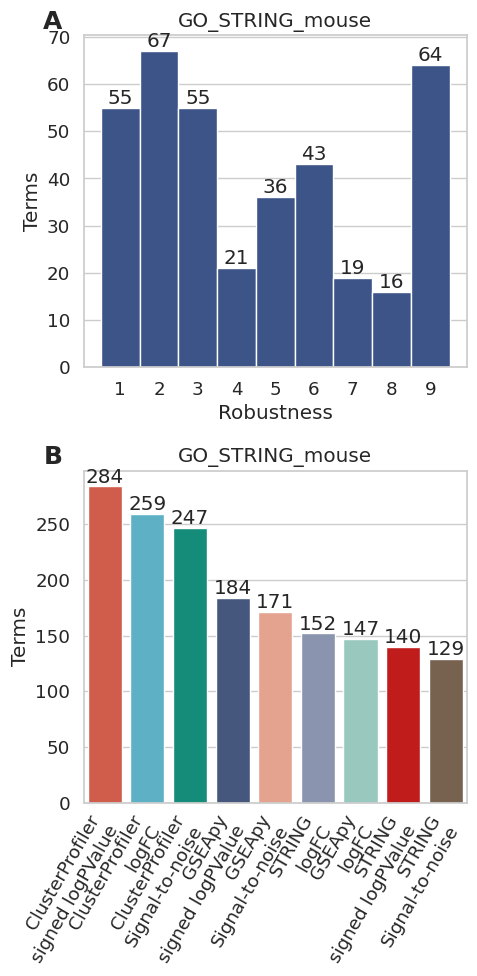

In [48]:
palette = npg

sns.set_theme(font_scale=1.2)

nlib = len(lib_names.keys())

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(2, nlib, figsize=(nlib*5,10))
axes = axes.flatten()
qval = 0.05

### Intersection depth

for ax, lib in zip(axes[:nlib],lib_names.keys()):
    depth_df = summary_dict[lib]["depth_df"]
    if len(depth_df) < 1:
        print(f"No terms found for {lib}")
        continue
    h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[3])
    h.bar_label(h.containers[0])
    ax.set(title=lib, xlabel="Robustness", ylabel="Terms")
    ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
    ax.grid(axis='x')        
    
### Number of terms

for ax, lib in zip(axes[nlib:], lib_names.keys()):
    summary_df = summary_dict[lib]["summary_df"]
    qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
    qv = qv.xs("qvalue", level=2, axis=1)
    qv = qv.replace(np.nan,1)
    qv = qv < qval

    qqv=qv.sum().reset_index()
    qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
    qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
    qqv = qqv.drop(["Tool","Metric"], axis=1)
    qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

    if ax == axes[nlib]:
        hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

    qqv["hue"] = qqv.index
    b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
    for i in b.containers:
        b.bar_label(i,)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
    ax.set(title=lib, ylabel="Terms", xlabel=None)
    
    # apply offset transform to all x ticklabels.
    offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

fig.tight_layout()
fig.savefig(f"{figpath}/bars.{project_name}.pdf")

# include_bidirectional = True
# s = summary_df.xs("Direction",axis=1,level=2)
# bidirectional_ix = s[(s == "Both").any(axis=1)].index
# summary_df.loc[bidirectional_ix]

## Venn diagrams

TypeError: 'Axes' object is not subscriptable

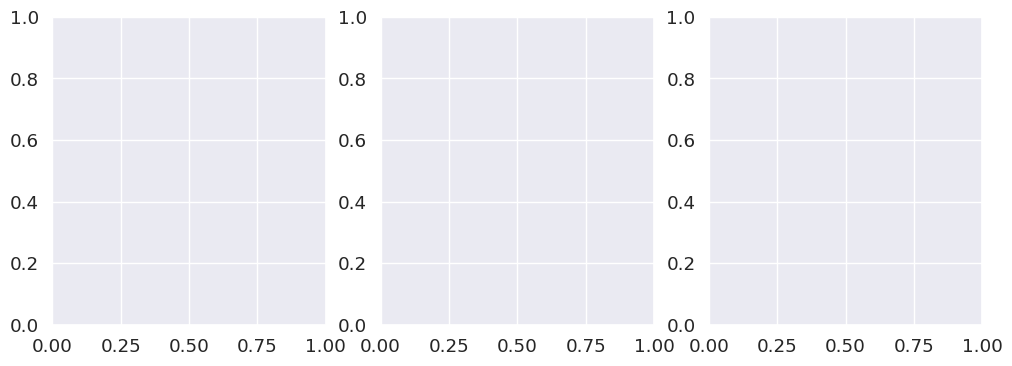

In [49]:
from scripts.explore_results import get_sig_dict
from scripts.plots import plot_venn

fig, ax = plt.subplots(len(lib_names.keys()), len(metrics), figsize=(len(metrics)*4,len(lib_names.keys())*4))

for i, lib in enumerate(lib_names.keys()):
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, metric in enumerate(metrics):
        plot_venn(sig_dict, tools, metric, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[metric]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig(f"{figpath}/venn.methodcomp.{project_name}.pdf")


fig, ax = plt.subplots(len(lib_names.keys()), 3, figsize=(12,len(lib_names.keys())*4))

for i, lib in enumerate(lib_names.keys()):
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, tool in enumerate(tools):
        plot_venn(sig_dict, tool, metrics, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[tool]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig(f"{figpath}/venn.metriccomp.{project_name}.pdf")

## UpSet plots

Useful for visualizing set intersection with more than 3 sets. 

https://upsetplot.readthedocs.io/en/stable/index.html

/home/peter/Work/OmicsPhD/SynEnrich/.snakemake/conda/feef0e19cdfb93ecb7ae27ffb0b0ac38_/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/peter/Work/OmicsPhD/SynEnrich/.snakemake/conda/feef0e19cdfb93ecb7ae27ffb0b0ac38_/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] =

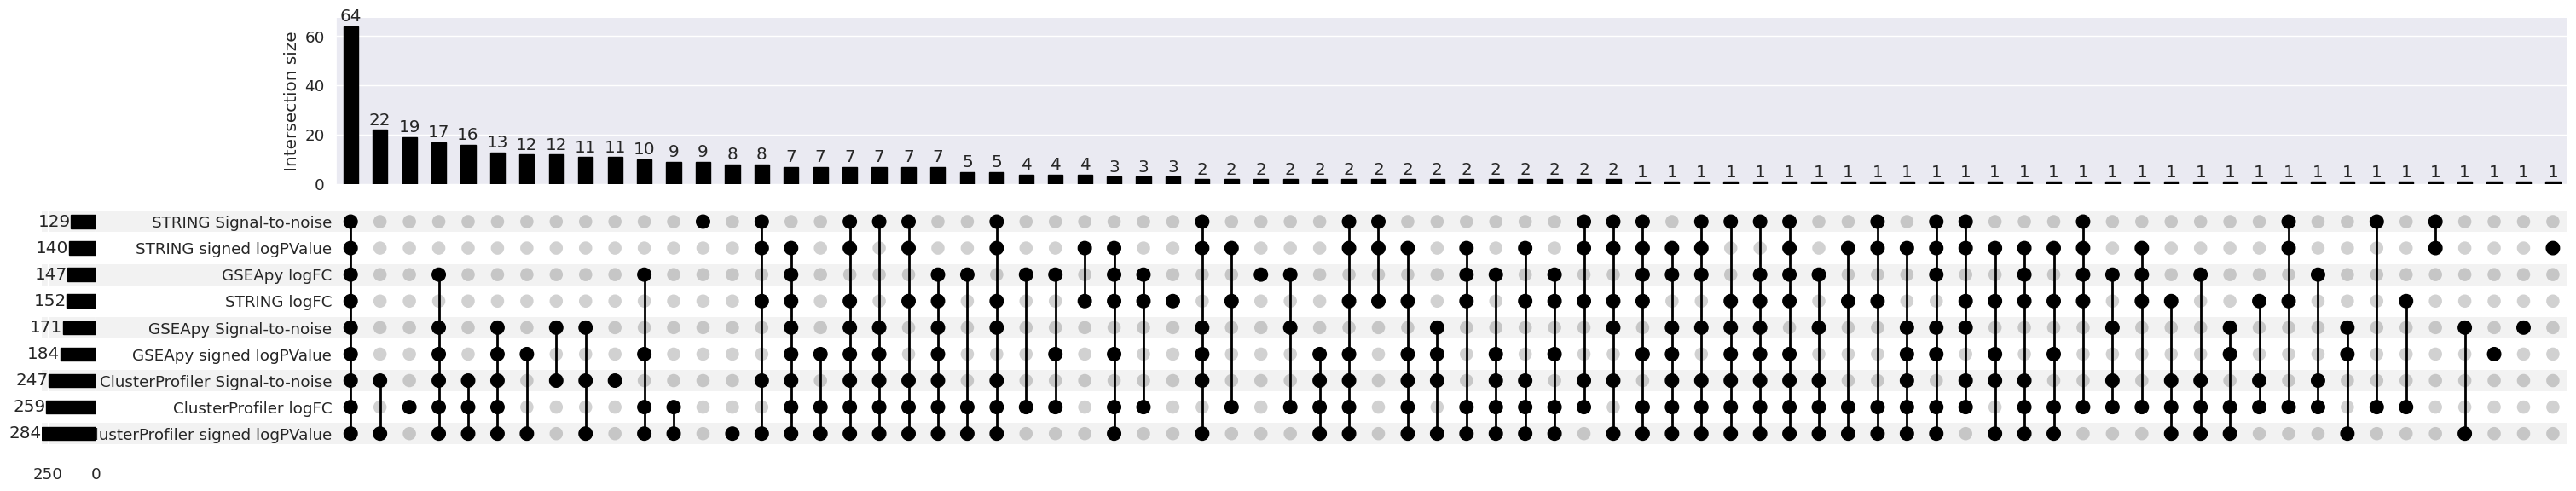

In [50]:
from matplotlib import pyplot
from upsetplot import from_memberships
from upsetplot import UpSet

for lib in lib_names.keys():

    depth_df = summary_dict[lib]["depth_df"]
    if len(depth_df) < 1:
        print(f"No terms found for {lib}")
        continue
    memberships = depth_df["Configurations"]
    memberships_list = [categories.split(" | ") for categories in memberships.values]
    upset_ready = from_memberships(memberships_list)
    upset_ready.index.names = [" ".join([pretty_print[i] for i in u.split(".")]) for u in upset_ready.index.names] # pretty print

    pd.options.mode.copy_on_write = False
    UpSet(upset_ready, subset_size="count", sort_by="cardinality", show_counts="{:,}").plot()
    pd.options.mode.copy_on_write = True
    pyplot.savefig(f"{figpath}/upset.{lib}.{project_name}.pdf")

## Lollipop

In [51]:
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def make_lollipop(df, lib, project_name, max_depth=0, ext="pdf", title=None):

    df["SignedDepth"] = df["Depth"] * df["Direction"].apply(lambda x: 1 if x == "Up" else 0 if x == "Both" else -1)
    df["logFDR"] = -np.log10(df["Combined FDR"])
    ordered_df = df.sort_values(by="SignedDepth")

    my_range=range(1,len(df.index)+1)

    max_label_length = max(len(label) for label in ordered_df["Description"])
    
    with sns.axes_style("ticks"):
        fig_width = 4 + max_label_length * 0.08
        fig_height = max(1.8,len(df)//3)
        fig, ax = plt.subplots(1,1,figsize=(fig_width,fig_height))


    ax.hlines(y=my_range, xmin=0, xmax=ordered_df["SignedDepth"], zorder=98, color="grey")
    sns.scatterplot(data=ordered_df, x="SignedDepth", y=range(1,1+len(ordered_df)), hue="logFDR", ax=ax, zorder=99, s=100)

    ax.set_yticks(my_range, ordered_df['Description'])

    ax.set(title=f"Top {lib} terms {project_name}" if title == None else title)

    ### COLOR BAR
    cmap = sns.cubehelix_palette(as_cmap=True)
    norm = plt.Normalize(ordered_df['logFDR'].min(), ordered_df['logFDR'].max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    fig.colorbar(sm, cax=cax)
    #clb.ax.set_title('This is a title')
    fig.axes[1].set(title='-logFDR', xlabel='', ylabel='')


    # some extra spacing top and bottom
    ax.set_ylim(my_range[0]-1, my_range[-1]+1)

    if max_depth:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        #ax.set_xticks(range(-max_depth, max_depth+1))

    if max_depth > 0:
        low, high = ax.get_xlim()
        if ordered_df["SignedDepth"].max() > 0: high = max_depth + 0.5
        if ordered_df["SignedDepth"].min() < 0: low = -max_depth-0.5
        ax.set_xlim(low,high)
        if low == -max_depth-0.5 and high == max_depth + 0.5:
            ax.axvline(0, ls="--",color="grey")

    fig.tight_layout()
    fig.savefig(f"../../results/{project_name}/figures/lollipop.{lib}.{project_name}.{ext}")

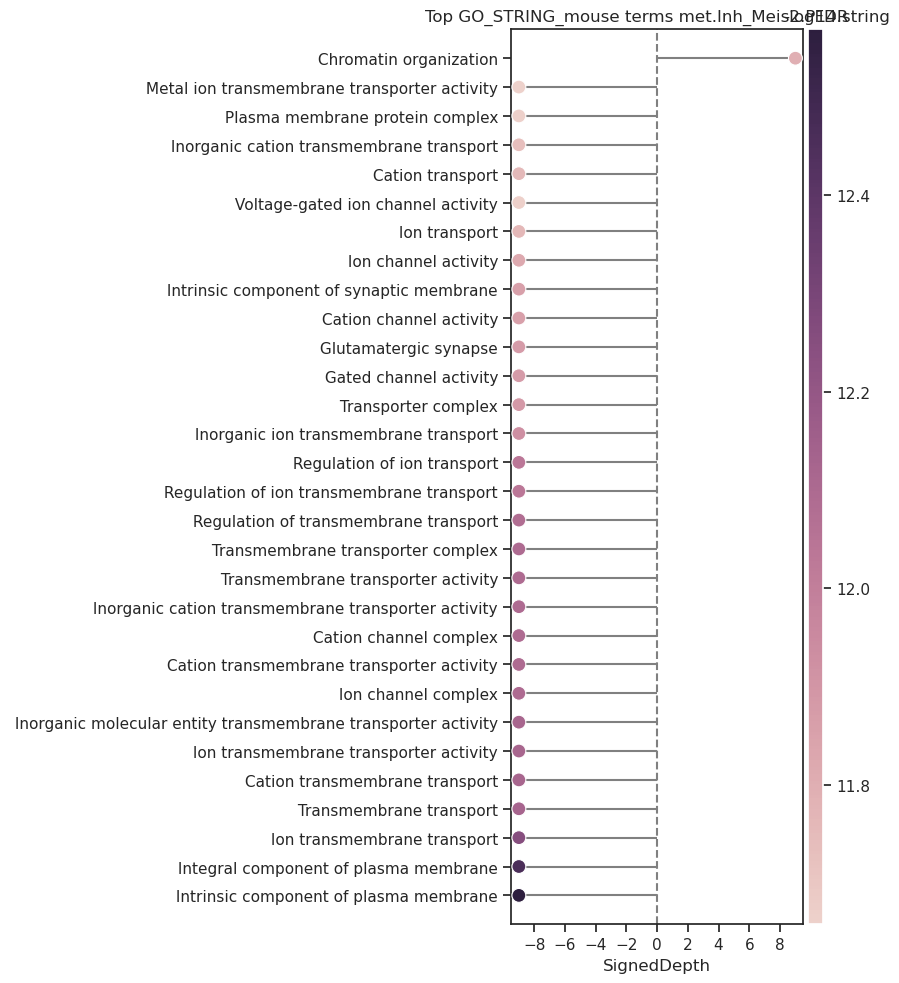

In [52]:
sns.set_theme(font_scale=1)

for lib in lib_names.keys():

    d = summary_dict[lib]["depth_df"]
    if len(d) < 1:
        print(f"No terms found for {lib}")
        continue
    if "Direction" not in d:
        d["Direction"] = d.index.str.split("_").str[1].str.strip()
    d.index = d.index.str.split("_").str[0]
    d.rename({"Factors":"Configurations"}, axis=1, inplace=True)
    d["Combined FDR"] = summary_dict[lib]["summary_df"].loc[d.index,("Combined","nan","Combined FDR")]
    d.sort_values(by=["Depth","Combined FDR"], ascending=[False,True], inplace=True)
    outfile = f"../../results/{project_name}/combined/syn.depth.{lib}.{project_name}.csv"
    d = d[["Description","Depth","Direction","Combined FDR","Configurations"]]
    d.to_csv(outfile)
    
    dd = d[(d["Depth"]>1) & (d["Combined FDR"]< 0.05)]
    if len(dd) < 1:
        print(f"No terms found for {lib}")
        continue

    title= f"Top {lib} terms {project_name}"
    make_lollipop(dd.iloc[:30], lib, project_name, ext="pdf", max_depth = 9, title=title)

# Meta-analysis

Compare multiple datasets

In [ ]:
import pickle
from scripts.plots import npg_palette

npg = npg_palette()

#project_names = ["BRCA.LRT", "Carmen.unpaired.LRT", "Chiara.KO_WT", "Chiara.SA_WT", "met.Exc7_DL.P90.p19rc"]
project_names = ["THCA.QLF","BRCA.QLF", "KIRC.QLF", "LIHC.QLF",
                 "Carmen.paired.QLF", 
                 "Chiara.QLF.KO_WT", "Chiara.QLF.SA_WT", "Chiara.QLF.SD_WT",
                 "met.Exc7_DL.P90.p19rc", "met.Inh_Sncg.P14.p19rc"]

pretty_datanames = {"BRCA.QLF":"TCGA.BRCA.N-T",
                    "THCA.QLF":"TCGA.THCA.N-T",
                    "KIRC.QLF":"TCGA.KIRC.N-T",
                    "LIHC.QLF":"TCGA.LIHC.N-T",
                    "met.Exc7_DL.P90.p19rc": "sn.Exc7.P90.WT-SA",
                    "met.Inh_Sncg.P14.p19rc": "sn.Inh.Sncg.P14.WT-SA",
                    "Chiara.QLF.KO_WT":"Ser1016.WT-KO",
                    "Chiara.QLF.SA_WT":"Ser1016.WT-SA",
                    "Chiara.QLF.SD_WT":"Ser1016.WT-SD",
                    "Carmen.paired.QLF":"CHK2.WT-KO"}

meta_dict = dict()
for project in project_names:
    try:
        with open(f"../../results/{project}/{project}.summary_dict.txt", "rb") as f:
            meta_dict[project] = pickle.load(f)
    except FileNotFoundError:
        print(f"Project not found: {project}")

npg

In [ ]:
meta_depth_dict = dict()

for lib in libraries:
    meta_depth_df = []
    for project in meta_dict:
        depth_df_p = meta_dict[project][lib]["depth_df"]
        depth_df_p["Project"] = project
        depth_df_p.replace({"Project":pretty_datanames}, inplace=True)
        meta_depth_df.append(depth_df_p)

    meta_depth_df = pd.concat(meta_depth_df)
    meta_depth_dict[lib] = meta_depth_df

In [ ]:
meta_summary_dict = dict()

for lib in libraries:
    meta_summary_df = []
    for project in meta_dict:
        df = meta_dict[project][lib]["summary_df"]
        df.index = df.index + "." + project # needed for venn
        meta_summary_df.append(df)

    meta_summary_df = pd.concat(meta_summary_df)
    meta_summary_dict[lib] = meta_summary_df

In [ ]:
import matplotlib

palette = npg

sns.set(font_scale=1.2)
#sns.set_style("whitegrid")
sns.set_style("ticks")

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

### Intersection depth

for ax, lib in zip(axes[:2],meta_depth_dict):
    sns.despine()
    depth_df = meta_depth_dict[lib]
    h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[3], label="Non-TCGA")
    h.bar_label(h.containers[0])
    ax.set(title=lib, xlabel="Intersection Depth", ylabel="Terms")
    ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
    ax.grid(axis='x')

    ### plot TCGA only on top
    TCGA = depth_df[depth_df["Project"].str.startswith("TCGA")]
    sns.histplot(TCGA['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[5], label="TCGA")
    
    ### label bars    
    nonTCGA = depth_df[~depth_df["Project"].str.startswith("TCGA")]
    nonTCGA_counts = nonTCGA['Depth'].value_counts().sort_index()
    TCGA_counts = TCGA['Depth'].value_counts().sort_index()
    for i in range(depth_df["Depth"].max()):
        ax.text(s=TCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]/2,  va='center',ha='center')
        ax.text(s=nonTCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]+nonTCGA_counts.iloc[i]/2,  va='center',ha='center',color="white")

    ax.legend(loc="best")
    ax.grid(False)

    if ax == axes[0]:
        pass#ax.set_ylim(0,349)

### Number of terms

for ax, lib in zip(axes[2:], meta_summary_dict):
    sns.despine()
    summary_df = meta_summary_dict[lib]
    qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
    qv = qv.xs("qvalue", level=2, axis=1)
    qv = qv.replace(np.nan,1)
    qv = qv < qval

    qqv=qv.sum().reset_index()
    qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
    qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
    qqv = qqv.drop(["Tool","Metric"], axis=1)
    qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

    if ax == axes[2]:
        hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

    qqv["hue"] = qqv.index
    b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
    for i in b.containers:
        b.bar_label(i,)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
    ax.set(title=lib, ylabel="Terms", xlabel=None)

    # apply offset transform to all x ticklabels.
    offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
        
for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

fig.tight_layout()
fig.savefig("../../results/meta/bars.meta.pdf")

In [ ]:
from scripts.plots import plot_venn

fig, ax = plt.subplots(2, 2, figsize=(8,8))

for i, lib in enumerate(libraries):
    summary_df = meta_summary_dict[lib]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, metric in enumerate(metrics):
        plot_venn(sig_dict, tools, metric, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[metric]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig("../../results/meta/venn.methodcomp.meta.pdf")


fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, lib in enumerate(libraries):
    summary_df = meta_summary_dict[lib]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, tool in enumerate(tools):
        plot_venn(sig_dict, tool, metrics, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[tool]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig("../../results/meta/venn.metriccomp.meta.pdf")

In [ ]:
from matplotlib import pyplot
from upsetplot import from_memberships, UpSet

for lib in libraries:

    depth_df = meta_depth_dict[lib]
    memberships = depth_df["Factors"]
    memberships_list = [categories.split(" | ") for categories in memberships.values]
    upset_ready = from_memberships(memberships_list)
    upset_ready.index.names = [" ".join([pretty_print[i] for i in u.split(".")]) for u in upset_ready.index.names] # pretty print

    pd.options.mode.copy_on_write = False
    UpSet(upset_ready, subset_size="count", sort_by="cardinality", show_counts="{:,}", orientation="vertical").plot()
    pd.options.mode.copy_on_write = True
    pyplot.savefig(f"../../results/meta/upset.{lib}.meta.pdf", bbox_inches='tight')

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

### Number of terms per dataset

for ax, lib in zip(axes[:2],libraries):
    sns.despine()
    depth_df = meta_depth_dict[lib]
    depth_df.replace({"Project":pretty_datanames}, inplace=True)

    counts = depth_df.groupby(["Project"]).count()["Factors"].sort_values(ascending=False)

    counts = pd.DataFrame(counts)

    counts["hue"] = counts.index
    #counts.replace({"hue":pretty_datanames}, inplace=True)

    if ax == axes[0]:
        hue_order = {counts.iloc[i]["hue"]: npg[i] for i in range(len(counts))}
        
    b = sns.barplot(data=counts, y="Factors", x="hue", ax=ax, hue="hue", hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(title=lib,xlabel=None,ylabel="Combined Terms")

    for i in b.containers:
        b.bar_label(i,)

    if ax == axes[1]:
        ax.set_ylim(0,2999)
    
    if ax == axes[0]:
        ax.set_ylim(0,199)

    # mark depths with horzontal lines
    g = depth_df.groupby(["Project"])["Depth"].value_counts()
    for j, p in enumerate(counts.index):
        sum = 0
        prev_sum = 0
        maxdepth = g.index.get_level_values("Depth").max()
        for i in range(1,1+maxdepth):
            try:
                sum += g.loc[(p,i)]
            except KeyError:
                pass
            if i < maxdepth:
                ax.scatter(j, sum, marker="_", color="black", s=550, alpha=0.5)
            if j == 0:
                ax.text(s=f"d{i}",x=j,y=prev_sum + 0.5*(sum-prev_sum), ha="center", va="center",fontsize=10)
            prev_sum = sum

for ax, lib in zip(axes[2:], libraries):
    depth_df = meta_depth_dict[lib]
    #depth_df.replace({"Project":pretty_datanames}, inplace=True)
    #sns.barplot(data=depth_df, x="Project", y="Depth", hue="Project", errorbar="sd", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    sns.boxplot(data=depth_df, x="Project", y="Depth", hue="Project", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(ylabel="Enrichment Depth",title=lib)

    if ax == axes[3]:
        ax.set_ylim(axes[2].get_ylim())

for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)
    axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=30, ha='right')
    axes[i].set(xlabel=None)

    # annotate KI
    axes[i].axvline(len(pretty_datanames)-4.5,0,axes[i].get_ylim()[1],ls="--",color="black",alpha=0.7)
    #axes[i].annotate("KI", xy=(0,0), xytext=(len(pretty_datanames)-3, 0.8*axes[i].get_ylim()[1] ), xycoords="data",zorder=99)

    if i == 0:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.8), xycoords="axes fraction",zorder=99)
    elif i == 1:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.735), xycoords="axes fraction",zorder=99)
    elif i == 2:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)
    else:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)

fig.tight_layout()
fig.savefig("../../results/meta/bars.data.meta.pdf")

# Utilities

## Format STRING table

User can (optionally) manually add [STRING](https://string-db.org/cgi/input?sessionId=b9myRH3ZDO2O&input_page_active_form=proteins_with_values) functional scoring output tables to the results folder, and they will be combined with the output from SynEnrich. For this, STRING tables have to be formatted first:

1) Download the .tsv file from the STRING web tool and save it in `results/{project_name}`.

2) Rename the file to `syn.string.{metric}.{project_name}.tsv` where {metric} is to be replaced with the ranking metric (e.g. logFC) and {project_name} with the project name specified at the beginning of this notebook.

3) Use the cell below to format the STRING table (which will split the file in separate KEGG and GO tables and rename some columns)

In [ ]:
from scripts.utils import format_string_table

string_file1 = f"{savepath}/syn.string.logFC.{project_name}.tsv"
string_file2 = f"{savepath}/syn.string.neg_signed_logpval.{project_name}.tsv"
string_file3 = f"{savepath}/syn.string.s2n.{project_name}.tsv"

string_files = [string_file1, string_file2, string_file3]

for string_file in string_files:

    string = pd.read_csv(string_file, index_col=0, sep="\t")

    for library in ["GO", "KEGG"]:
        string_formatted = format_string_table(string, library)
        #display(string_formatted.head())
        string_formatted.to_csv(string_file.replace(f"{project_name}.tsv", f"{library}.{project_name}.csv"))

The cell below can be used to split the input table into several files for each ranking metric, which is convenient for uploading to STRING.


In [ ]:
df = pd.read_csv("../../"+input_file, index_col=0)
p = "../../" + "/".join(input_file.split("/")[:-1])
name = input_file.split("/")[-1]
for metric in metrics:
    print(len(df[metric]))
    df[metric] = df[metric].dropna()
    print(len(dff))
    dff.to_csv(os.path.join(p,f"string.input.{metric}."+name), header=False)

# from scripts import combine_libs
# import importlib
# importlib.reload(combine_libs)